In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import const
from scipy.special import erf
import json
from types import SimpleNamespace
from pp import calc_conf_per, calc_conf_boot, save_fig


In [6]:
info_path = "/global/homes/a/andalman/scratch/fiducial/info.txt"
data_path = "/global/homes/a/andalman/scratch/fiducial/data.txt"
beta_spec_path = "/global/homes/a/andalman/thunderstorm/resources/beta_spec.json"


In [7]:
with open(beta_spec_path, "r") as f:
    data_beta_spec = SimpleNamespace(**json.load(f))
data_beta_spec.ener = np.array(data_beta_spec.ener)
data_beta_spec.beta_spec = np.array(data_beta_spec.beta_spec)


In [8]:
with open(info_path, "r") as file:
    info_lines = file.readlines()

ener_list     = np.array(info_lines[10].split(",")).astype(float)
ener_sec_bins = np.array(info_lines[12].split(",")).astype(float)
time_bins     = np.array(info_lines[14].split(",")).astype(float)
dis_bins      = np.array(info_lines[16].split(",")).astype(float)

ener_sec_list = np.sqrt(ener_sec_bins[:-1] * ener_sec_bins[1:])
#time_list = np.sqrt(time_bins[1:] * time_bins[:-1])
time_list = (time_bins[1:] + time_bins[:-1]) / 2
#dis_list  = np.sqrt(dis_bins[1:] * dis_bins[:-1])
dis_list = (dis_bins[1:] + dis_bins[:-1]) / 2

num_ener = ener_list.size
num_ener_sec = ener_sec_list.size
num_time = time_list.size
num_dis = dis_list.size

num_line_1ener = int(info_lines[6].split()[-1])
num_line_1part = num_ener * num_line_1ener


In [9]:
with open(data_path, "r") as file:
    data_lines = np.array(file.readlines())
    
num_part = data_lines.size // num_line_1part


In [10]:
id_list = np.zeros((num_part))
num_ev_list = np.zeros((num_part, num_ener))
t_start_list = np.zeros((num_part, num_ener))
x_start_list = np.zeros((num_part, num_ener))
y_start_list = np.zeros((num_part, num_ener))
z_start_list = np.zeros((num_part, num_ener))
ener_loss_mech_list = np.zeros((num_part, num_ener, 6))
num_ion_list = np.zeros((num_part, num_ener, 118))
num_sec_list = np.zeros((num_part, num_ener, num_ener_sec))
ener_time_list = np.zeros((num_part, num_ener, num_time))
ener_loss_time_list = np.zeros((num_part, num_ener, num_time))
ener_loss_dis_list = np.zeros((num_part, num_ener, num_dis))

for i, data_lines_1part in enumerate(data_lines.reshape((-1, num_line_1part))):   
    for j, data_lines_1ener in enumerate(data_lines_1part.reshape((-1, num_line_1ener))):
        num_ev_list[i, j] = int(data_lines_1ener[1])
        t_start_list[i, j], x_start_list[i, j], y_start_list[i, j], z_start_list[i, j] = np.array(data_lines_1ener[2].split(","), dtype=float)
        ener_loss_mech_list[i, j] = np.array(data_lines_1ener[3].split(","), dtype=float)
        num_ion_list[i, j] = np.array(data_lines_1ener[4].split(","), dtype=int)
        num_sec_list[i, j] = np.array(data_lines_1ener[5].split(","), dtype=int)
        ener_time_list[i, j] = np.array(data_lines_1ener[6].split(","), dtype=float)
        ener_loss_time_list[i, j] = np.array(data_lines_1ener[7].split(","), dtype=float)
        ener_loss_dis_list[i, j] = np.array(data_lines_1ener[8].split(","), dtype=float)


Text(0, 0.5, '$E_{\\rm loss} / E_{\\rm init}$ [$\\%$]')

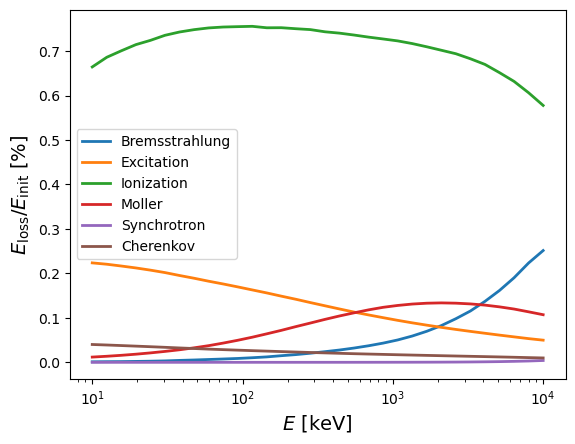

In [18]:
ener_loss_avg = np.mean(ener_loss_mech_list, axis=0)

plt.xscale('log')
plt.plot(ener_list/1e3, ener_loss_avg[:,0]/ener_list, lw=2, label='Bremsstrahlung')
plt.plot(ener_list/1e3, ener_loss_avg[:,1]/ener_list, lw=2, label='Excitation')
plt.plot(ener_list/1e3, ener_loss_avg[:,2]/ener_list, lw=2, label='Ionization')
plt.plot(ener_list/1e3, ener_loss_avg[:,3]/ener_list, lw=2, label='Moller')
plt.plot(ener_list/1e3, ener_loss_avg[:,4]/ener_list, lw=2, label='Synchrotron')
plt.plot(ener_list/1e3, ener_loss_avg[:,5]/ener_list, lw=2, label='Cherenkov')
plt.legend()

plt.xlabel(r"$E$ [${\rm keV}$]", fontsize=14)
plt.ylabel(r"$E_{\rm loss} / E_{\rm init}$ [$\%$]", fontsize=14)


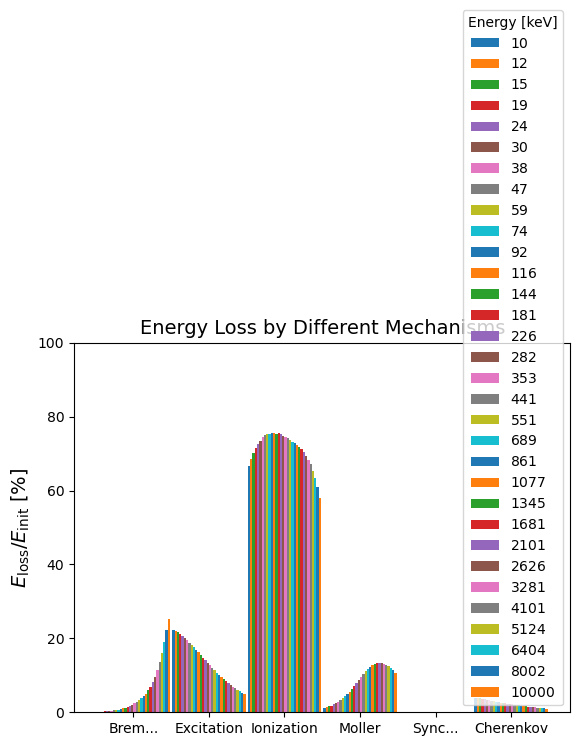

In [ ]:
fig, ax = plt.subplots()

width = 1 / (num_ener + 1)
ener_loss_avg = np.mean(ener_loss_mech_list, axis=0)
ener_loss_std = np.std(ener_loss_mech_list, axis=0)

for i in range(num_ener):

    offset = (i - (num_ener-1)/2) * width
    ener_init = ener_list[i]
    ax.bar(np.arange(6)+offset, 100*ener_loss_avg[i]/ener_init, width=width, label=r'$%d$' % (ener_init/1e3))
    #ax.errorbar(np.arange(6)+offset, 100*ener_loss_avg[i]/ener_init, yerr=100*ener_loss_std[i]/ener_init, color='red', zorder=1, linestyle='', capsize=5, elinewidth=3, capthick=3)
    
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['Brem...', 'Excitation', 'Ionization', 'Moller', 'Sync...', 'Cherenkov'])
ax.set_ylabel(r'$E_{\rm loss} / E_{\rm init}$ [$\%$]', fontsize=14)
ax.set_title('Energy Loss by Different Mechanisms', fontsize=14)
ax.set_ylim(0, 100)
ax.legend(title='Energy [keV]')


1077110.0


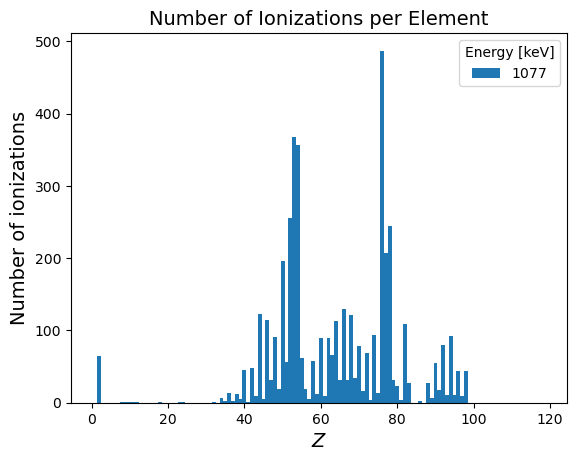

In [20]:
fig, ax = plt.subplots()

num_ion_avg = np.mean(num_ion_list, axis=0)
#num_ion_std = np.std(num_ion_list[:, idx_ener], axis=0)

i = 21
print(ener_list[i])

ax.bar(np.arange(118)+1, num_ion_avg[i], width=1, zorder=-i, label=r'$%d$' % (ener_list[i]/1e3))
#ax.errorbar(np.arange(118)+1, num_ion_avg[i], yerr=num_ion_std[i], color='red', zorder=1, linestyle='', capsize=1.5)

ax.set_xlabel(r'$Z$', fontsize=14)
ax.set_ylabel(r'Number of ionizations', fontsize=14)
ax.set_title('Number of Ionizations per Element', fontsize=14)
ax.legend(title='Energy [keV]')


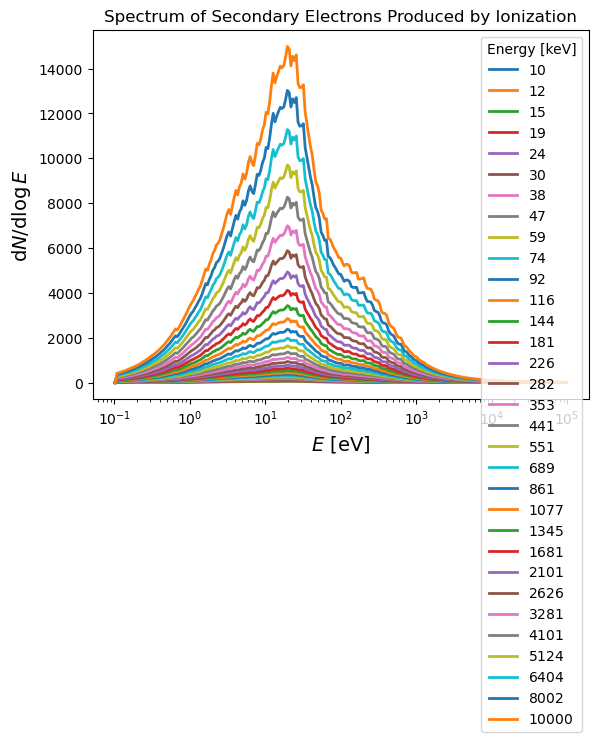

In [57]:
fig, ax = plt.subplots()

num_sec_avg = np.mean(num_sec_list, axis=0)
dlogE = np.log10(ener_sec_bins)[1:] - np.log10(ener_sec_bins)[:-1]

for i in range(num_ener):

    ax.plot(ener_sec_list, num_sec_avg[i]/dlogE, lw=2, label=r'$%d$' % (ener_list[i]/1e3))

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$E$ $[{\rm eV}]$', fontsize=14)
ax.set_ylabel(r'${\rm d}N/{\rm d}\log E$', fontsize=14)
ax.set_title('Spectrum of Secondary Electrons Produced by Ionization')
ax.legend(title='Energy [keV]')

#save_fig('spec_ion')


Text(0.5, 1.0, 'Energy vs. Time')

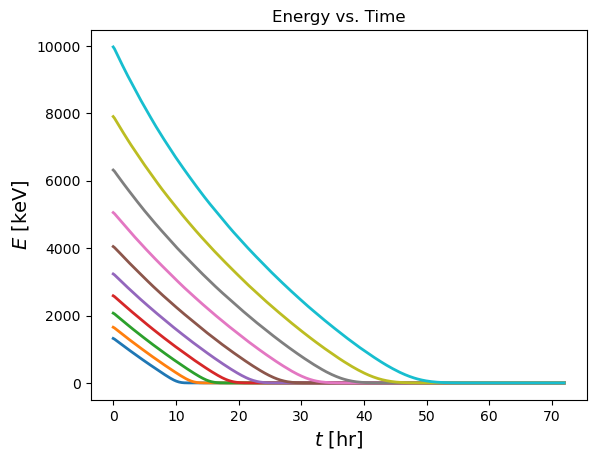

In [58]:
fig, ax = plt.subplots()

ener_time_avg = np.mean(ener_time_list, axis=0)

idx_ener = -10
ax.plot(time_list/const.hr, ener_time_avg[idx_ener:].T/1e3, lw=2,)
   
ax.set_xlabel(r'$t$ $[{\rm hr}]$', fontsize=14)
ax.set_ylabel(r'$E$ $[{\rm keV}]$', fontsize=14)
ax.set_title('Energy vs. Time')
#ax.set_xlim(0, 0.1)
#ax.set_xscale('log')
    

Text(0.5, 1.0, 'Energy Loss Rate vs. Time')

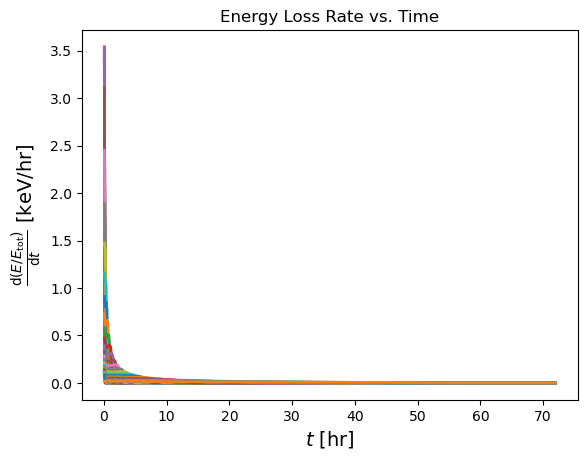

In [75]:
fig, ax = plt.subplots()

ener_loss_time_avg = np.mean(ener_loss_time_list, axis=0)

for idx_ener in range(num_ener):
    ener_init = ener_list[idx_ener]
    ax.plot(time_list/const.hr, ener_loss_time_avg[idx_ener]/(1e3/const.hr)/ener_init, lw=2, color='C%d'%idx_ener)
    
ax.set_xlabel(r'$t$ $[{\rm hr}]$', fontsize=14)
ax.set_ylabel(r'$\frac{{\rm d}(E/E_{\rm tot})}{{\rm d}t}$ $[{\rm keV/hr}]$', fontsize=14)
ax.set_title('Energy Loss Rate vs. Time')
    

Text(0.5, 1.0, 'Energy Deposition vs. Distance')

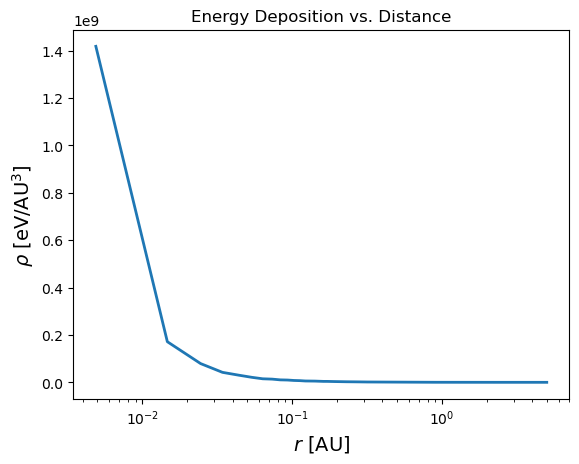

In [71]:
fig, ax = plt.subplots()

idx_ener = -1
ener_loss_dis_avg = np.mean(ener_loss_dis_list, axis=0)
dV = (dis_bins[1:] - dis_bins[:-1]) * 4*np.pi*dis_list**2
ax.plot(dis_list/const.AU, ener_loss_dis_avg[idx_ener]/dV/(1/const.AU**3), lw=2)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r"$r$ [${\rm AU}$]", fontsize=14)
ax.set_ylabel(r"$\rho$ [${\rm eV/AU^3}$]", fontsize=14)
ax.set_title('Energy Deposition vs. Distance')

#save_fig('ener_dis')


861954.0

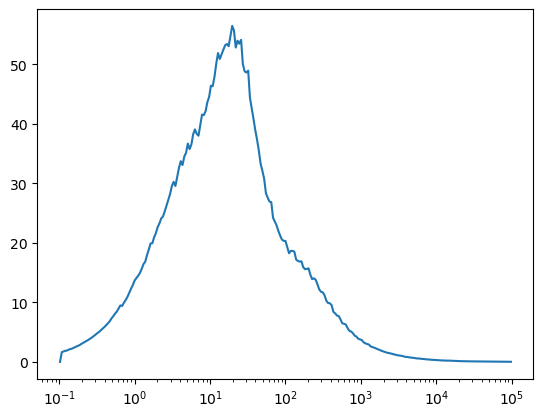

In [206]:
idx = -12
plt.plot(ener_sec_list, num_sec_avg[idx])
plt.xscale('log')
ener_list[idx]


In [11]:
Zmax = 118
ion_rate_prim = np.zeros(Zmax)
ion_rate_sec  = np.zeros(Zmax)
ion_rate_ter  = np.zeros(Zmax)
sec_spec = np.zeros(ener_sec_list.size)
ter_spec = np.zeros(ener_sec_list.size)

num_ion_avg = np.mean(num_ion_list, axis=0)
num_sec_avg = np.mean(num_sec_list, axis=0)

ener_bins = np.zeros(ener_list.size + 1)
ener_bins[0] = ener_list[0] / np.sqrt(ener_list[1] / ener_list[0])
ener_bins[1:-1] = ener_list[:-1] * np.sqrt(ener_list[1:] / ener_list[:-1])
ener_bins[-1] = ener_list[-1] * np.sqrt(ener_list[-1] / ener_list[-2])

for i in range(ener_list.size):
    idx_min = np.searchsorted(data_beta_spec.ener/const.eV, ener_bins[i])
    idx_max = np.searchsorted(data_beta_spec.ener/const.eV, ener_bins[i+1])
    decay_rate = np.trapz(data_beta_spec.beta_spec[idx_min:idx_max], np.log10(data_beta_spec.ener[idx_min:idx_max]))
    ion_rate_prim += num_ion_avg[i] * decay_rate
    sec_spec += num_sec_avg[i] * decay_rate / np.log10(ener_sec_bins[1:] / ener_sec_bins[:-1])
    
for i in range(ener_list.size):
    idx_min = np.searchsorted(ener_sec_list, ener_bins[i])
    idx_max = np.searchsorted(ener_sec_list, ener_bins[i+1])
    sec_rate = np.trapz(sec_spec[idx_min:idx_max], np.log10(ener_sec_list[idx_min:idx_max]))
    ion_rate_sec += num_ion_avg[i] * sec_rate
    ter_spec += num_sec_avg[i] * sec_rate / np.log10(ener_sec_bins[1:] / ener_sec_bins[:-1])
    
for i in range(ener_list.size):
    idx_min = np.searchsorted(ener_sec_list, ener_bins[i])
    idx_max = np.searchsorted(ener_sec_list, ener_bins[i+1])
    ter_rate = np.trapz(ter_spec[idx_min:idx_max], np.log10(ener_sec_list[idx_min:idx_max]))
    ion_rate_ter += num_ion_avg[i] * ter_rate


In [22]:
100 * np.sum(ion_rate_ter) / np.sum(ion_rate_prim + ion_rate_sec + ion_rate_ter)


0.2901686610532171

Saved figure as 'ion_rate-070420241146.png'


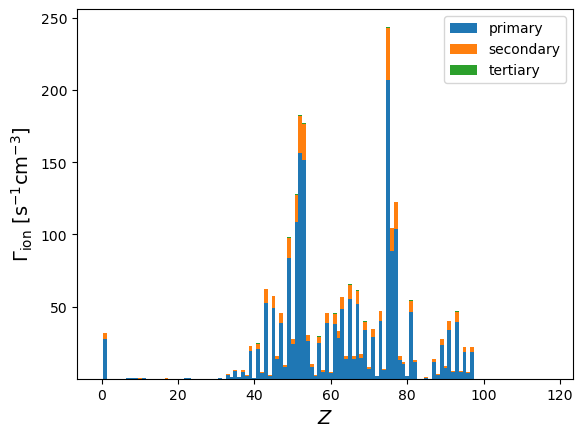

In [12]:
plt.bar(np.arange(Zmax), ion_rate_prim, width=1, label=r"primary")
plt.bar(np.arange(Zmax), ion_rate_sec, width=1, bottom=ion_rate_prim, label=r"secondary")
plt.bar(np.arange(Zmax), ion_rate_ter, width=1, bottom=ion_rate_prim+ion_rate_sec, label=r"tertiary")
plt.xlabel(r"$Z$", fontsize=14)
plt.ylabel(r"$\Gamma_{\rm ion}$ [${\rm s^{-1} cm^{-3}}$]", fontsize=14)
plt.legend()

#save_fig("ion_rate")
